In [1]:
import config
from vars import NUM_TYPE_MAPPING
import tensorflow.keras as keras
import tensorflow as tf
from CustomLossFunction import dice_coef
from Generator import DataGenerator
import Generator
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ModelBuilding import createModel

2021-11-28 18:31:57.551723: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-11-28 18:32:00.270554: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-28 18:32:00.541910: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-28 18:32:00.542001: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (antsun): /proc/driver/nvidia/version does not exist


In [2]:
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass


In [3]:
import os;
# os.chdir(config.BASE_DIR)
os.getcwd()
# config.BASE_MODEL_PATH

'/shared/WorkAttachment/code/MachineLearning'

In [4]:
model = keras.models.load_model(os.path.sep.join([config.BASE_OUTPUT,"models", "20201220", "latest_model"]), custom_objects={'dice_coef': dice_coef})#, compile=True)

2021-11-28 18:32:00.617702: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-28 18:32:00.856748: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4294967296 exceeds 10% of free system memory.
2021-11-28 18:32:03.938450: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4294967296 exceeds 10% of free system memory.
2021-11-28 18:32:09.481835: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4294967296 exceeds 10% of free system memory.
2021-11-28 18:32:22.333692: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4294967296 exceeds 10% of free system memory.
2021-11-28 18:32:22.916106: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocati

In [5]:
model = createModel()
losses = {
        "class_label": tf.keras.losses.categorical_crossentropy,
        "bounding_box": dice_coef,
    }
# model.load_weights(os.path.sep.join(["output","models","bests", "model.03-1.17.h5"]))
model.load_weights(os.path.sep.join([config.BASE_OUTPUT,"models","bests", "model.03-0.93.h5"]))
model.compile(loss=losses)

Creating model
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 64) 0           block1_conv2[0][0]               
_______________________________________________________________________________

In [6]:
datagen = DataGenerator(['kidneyHU.png', 'lungHU.png', 'liverHU.png', 'abdomenHU.png', 'boneHU.png', 'mediastinumHU.png', 'pelvisHU.png', 'softtissue.png'], os.sep.join(['img']), to_fit=False, csvpath=config.ANNOTS_PATH)

In [7]:
imgarrs = [Generator.imagePreprocessing(os.sep.join(['img',fn]), (512,512)) for fn in ['kidneyHU.png', 'lungHU.png', 'liverHU.png', 'abdomenHU.png', 'boneHU.png', 'mediastinumHU.png', 'pelvisHU.png', 'softtissue.png']]
imgarrs = np.array(imgarrs)
print(imgarrs.shape)

(8, 512, 512, 3)


In [8]:
output = model(imgarrs, training=False)

In [9]:
for i in range(len(output)):
    print(output[i].shape)

(8, 8)
(8, 512, 512, 1)


In [10]:
labels = ['kidneyHU.png', 'lungHU.png', 'liverHU.png', 'abdomenHU.png', 'boneHU.png', 'mediastinumHU.png', 'pelvisHU.png', 'softtissue.png']
for i in range(8):
    leison_types = output[0][i]
    aimg = output[1][i]
#     break
    # print(leison_types)
    print('image', i)
    num = np.argmax(leison_types)
    print('expected\t', labels[i] )
    print('results\t\t', num+1, NUM_TYPE_MAPPING[str(num+1)])
    print('='*30)
    # num = leison_types > 0.6
    # for index, j in enumerate(num):
    #     # print(j)
    #     if j:
    #         print(index+1, NUM_TYPE_MAPPING[str(index+1)], '\t', leison_types[index])

image 0
expected	 kidneyHU.png
results		 8 pelvis
image 1
expected	 lungHU.png
results		 5 lung
image 2
expected	 liverHU.png
results		 4 liver
image 3
expected	 abdomenHU.png
results		 4 liver
image 4
expected	 boneHU.png
results		 5 lung
image 5
expected	 mediastinumHU.png
results		 3 mediastinum
image 6
expected	 pelvisHU.png
results		 8 pelvis
image 7
expected	 softtissue.png
results		 7 soft tissue


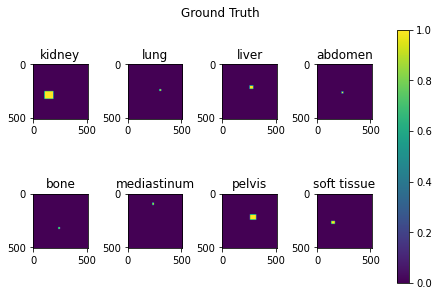

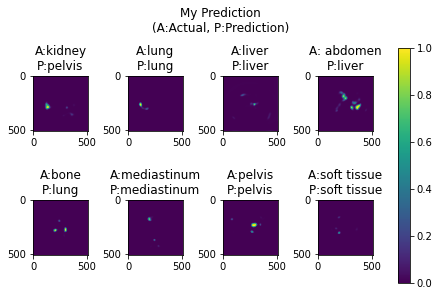

In [11]:
###############################################
############## ground truth plot ##############
###############################################

fig, axs = plt.subplots(2, 4,constrained_layout=True )
fn_title = [("000010_01_01_084.png", "kidney"),
("000004_02_02_073.png", "lung"),
("000016_01_01_008.png", "liver"),
("000002_01_01_162.png", "abdomen"),
("000010_02_02_100.png", "bone"),
("000001_01_01_109.png", "mediastinum"),
("000014_02_01_101.png", "pelvis"),
("000004_01_01_007.png", "soft tissue")]
for i in range(2):
    for j in range(4):
        img = axs[i,j].imshow(datagen._generate_y([fn_title[i*4+j][0]])["bounding_box"].reshape(512,512))
        axs[i,j].set_title(fn_title[i*4+j][1])
        
        
plt.colorbar(img, ax=axs)
fig.suptitle("Ground Truth")
plt.show()

###############################################
############### prediction plot ###############
###############################################

showProb = True  # whether to show the prediction as probability or a range of value
fig, axs = plt.subplots(2, 4, constrained_layout=True)
titles = ["kidney", "lung", "liver", " abdomen", "bone", "mediastinum", "pelvis", "soft tissue"]
maskList = []
plt.figure(100)
imgMaxRange = plt.imshow([[1,0]])
plt.close(100)
for i in range(2):
    for j in range(4):
        numpymask = np.array(output[1][i*4+j]).squeeze()
        maskList.append(numpymask>0.5)
        if not showProb:
            numpymask = numpymask > 0.5
        img = axs[i,j].imshow(numpymask)
        axs[i,j].set_title(f"A:{titles[i*4+j]}\nP:{NUM_TYPE_MAPPING[str(np.argmax(output[0][i*4+j])+1)]}")
        NUM_TYPE_MAPPING[str(num+1)]
        
plt.colorbar(imgMaxRange, ax=axs)
fig.suptitle("My Prediction\n(A:Actual, P:Prediction)")
plt.show()

/tmp/ipykernel_21192/546404666.py:20: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(imgMaxRange)


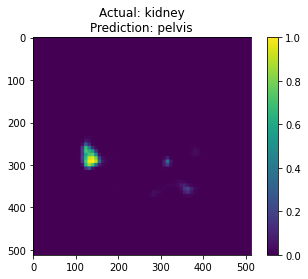

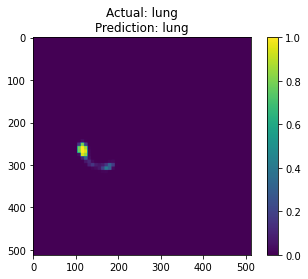

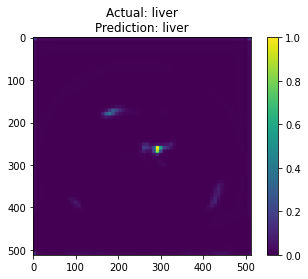

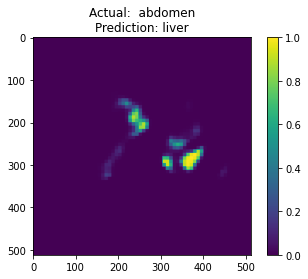

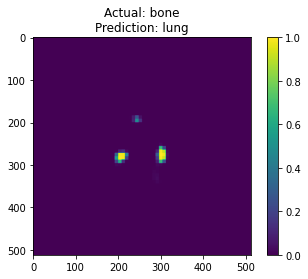

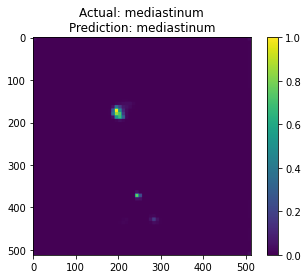

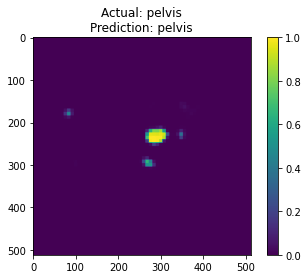

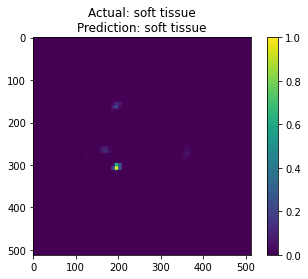

In [12]:
###############################################
########## Enlarged prediction plot ###########
###############################################

showProb = True  # whether to show the prediction as probability or a range of value
titles = ["kidney", "lung", "liver", " abdomen", "bone", "mediastinum", "pelvis", "soft tissue"]
maskList = []
plt.figure(100)
imgMaxRange = plt.imshow([[1,0]])
plt.close(100)
for i in range(8):
        plt.figure(i)
        numpymask = np.array(output[1][i]).squeeze()
        maskList.append(numpymask>0.5)
        if not showProb:
            numpymask = numpymask > 0.5
        img = plt.imshow(numpymask)
        plt.title(f"Actual: {titles[i]}\nPrediction: {NUM_TYPE_MAPPING[str(np.argmax(output[0][i])+1)]}")
        NUM_TYPE_MAPPING[str(num+1)]
        plt.colorbar(imgMaxRange)
plt.show()

In [13]:
import cv2
import config
import os
import numpy as np
import pandas as pd

fns = ['000010_01_01_084.png', '000004_02_02_073.png', '000016_01_01_008.png', '000002_01_01_162.png', '000010_02_02_100.png', '000001_01_01_109.png', '000014_02_01_101.png', '000004_01_01_007.png']

def genBboxCoord(csvpath, filenames):
    df = pd.read_csv(csvpath)
    coords_list = []
    for fn in filenames:
        temp_coord_list = []
        row = df[df["File_name"] == fn]
        bboxes = row["Bounding_boxes"].iloc[:]
        for i in range(len(row)):
            cur_coords = [float(j.strip()) for j in bboxes.iloc[i].split(",")]
            temp_coord_list.append(cur_coords)
        coords_list.append(temp_coord_list)
    return coords_list


coords = genBboxCoord(config.ANNOTS_PATH, fns)

for i, fn_and_coords in enumerate(zip(fns, coords)):
    mask = np.asarray(maskList[i], np.uint8)
    fn, coords = fn_and_coords
    img = cv2.imread(os.path.sep.join([config.IMAGES_PATH, fn]))
    mask.resize((512,512,1), refcheck=False)
    mask = np.repeat(mask, 3, axis=2)
    mask[:,:,:2] = 0
    mask *= 255
    alpha = 0.3
    img = cv2.addWeighted(np.asarray(mask, np.uint8), alpha, img, 1-alpha,0)

    for coord in coords:
        offset = 2
        pt1 = (int(coord[0] + offset), int(coord[1] + offset))
        pt2 = (int(coord[2] + offset), int(coord[3] + offset))
        img = cv2.rectangle(img, pt1, pt2, (255,0,0))
    
    cv2.imshow(str(i), img)
    cv2.waitKey(3000)
    
cv2.destroyAllWindows()
